In [ ]:
# pip install librosa
# import librosa
# folders = os.listdir("/content/Data/genres_original")           #check va peyda kardane file haye kharab
# last_one_is_error = []
# for folder in folders:
#   path = "/content/Data/genres_original" + '/' + folder
#   files = os.listdir(path)
#   for file in files:
#     data , sampling_rate = librosa.load(path + '/' + file)
#     data_tensor = tf.convert_to_tensor( data )
#     print(np.shape(data_tensor))
#     print(file)
#     spect = squeeze_by_avg(data_tensor, 1)
#     get_spectogram(spect[0], spect[1])

In [ ]:
# should_be_deleted = ['jazz.00071', 'jazz.00078', 'jazz.00096', 'jazz.00026', 'jazz.00054'] #Check shodan va kharab hastan
# for file in should_be_deleted:
#   os.remove(path+'/jazz/'+ file + '.wav')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import os
import shutil

In [ ]:
!unzip -q "/content/drive/MyDrive/Datasets/Music.zip"

In [ ]:
path = "/content/Musics"
seed = 5
batch = 16
train_dt, valid_dt = tf.keras.utils.audio_dataset_from_directory(path, validation_split=0.1 ,subset="both", seed=seed, batch_size= batch)

Found 2985 files belonging to 10 classes.
Using 2687 files for training.
Using 298 files for validation.


In [ ]:
def squeeze_by_avg(audio, labels):
  audio = tf.math.reduce_mean(audio, 2)
  return audio, labels

In [ ]:
train_dt = train_dt.map(squeeze_by_avg)
valid_dt = valid_dt.map(squeeze_by_avg)

In [ ]:
a, b = next(iter(train_dt))
np.shape(a)

TensorShape([16, 221173])

In [ ]:
def get_spectogram(voice, label):
  frame_length = 256
  frame_step = 128
  spect = tf.signal.stft(voice, frame_length= frame_length, frame_step= frame_step)
  spect = tf.abs(spect)
  spect = spect[... , tf.newaxis]
  return spect, label

In [ ]:
train_dt = train_dt.map(get_spectogram).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dt = valid_dt.map(get_spectogram).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
a, b = next(iter(valid_dt))
print(np.shape(a))
np.shape(b)

(16, 1722, 129, 1)


TensorShape([16])

In [ ]:
a, b = next(iter(train_dt))
print(np.shape(a))
np.shape(b)

(16, 1741, 129, 1)


TensorShape([16])

In [ ]:
Conv_kernel_size = (4,4)
strides = (2, 2)

In [ ]:
img_width = 1024
img_height = 129
model = tf.keras.models.Sequential([

    layers.Resizing(img_width, img_height),
    layers.Normalization(),
    layers.BatchNormalization(),

    layers.Conv2D(256, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #1
    layers.Conv2D(256, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #2
    layers.Conv2D(128, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #3

    layers.Reshape((img_width//8, (img_height//8)*128)),

    layers.GRU(512, return_sequences=True, dropout),
    layers.GRU(512),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(10)
])

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
red_lr = keras.callbacks.ReduceLROnPlateau(
                                          monitor="val_loss",
                                          factor=0.1,
                                          patience=2,
                                          mode="auto",
                                          min_delta=0.0001,
                                          cooldown=0,
                                          min_lr=0.0
                                          )

model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 10,
          callbacks = [red_lr]
          )

Epoch 1/10
168/168 [==============================] - 211s 1s/step - loss: 2.2338 - accuracy: 0.1548 - val_loss: 2.0788 - val_accuracy: 0.1846 - lr: 0.0010
Epoch 2/10
168/168 [==============================] - 153s 911ms/step - loss: 1.9854 - accuracy: 0.2386 - val_loss: 1.8328 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 3/10
168/168 [==============================] - 154s 917ms/step - loss: 1.7378 - accuracy: 0.3558 - val_loss: 1.5468 - val_accuracy: 0.3826 - lr: 0.0010
Epoch 4/10
168/168 [==============================] - 153s 914ms/step - loss: 1.5135 - accuracy: 0.4548 - val_loss: 1.3799 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 5/10
168/168 [==============================] - 153s 910ms/step - loss: 1.3421 - accuracy: 0.5147 - val_loss: 1.2543 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 6/10
168/168 [==============================] - 153s 914ms/step - loss: 1.1553 - accuracy: 0.5914 - val_loss: 1.0075 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 7/10
168/168 [=============================

In [ ]:
model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 5,
          callbacks = [red_lr]
          )

Epoch 1/5
168/168 [==============================] - 153s 909ms/step - loss: 0.6356 - accuracy: 0.7897 - val_loss: 0.8493 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 2/5
168/168 [==============================] - 153s 910ms/step - loss: 0.5239 - accuracy: 0.8284 - val_loss: 0.9080 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 3/5
168/168 [==============================] - 153s 912ms/step - loss: 0.4683 - accuracy: 0.8485 - val_loss: 0.8553 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 4/5
168/168 [==============================] - 153s 909ms/step - loss: 0.2406 - accuracy: 0.9248 - val_loss: 0.7459 - val_accuracy: 0.7886 - lr: 1.0000e-04
Epoch 5/5
168/168 [==============================] - 153s 912ms/step - loss: 0.1590 - accuracy: 0.9479 - val_loss: 0.7782 - val_accuracy: 0.8020 - lr: 1.0000e-04


KeyboardInterrupt: 

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 2,
          callbacks = [red_lr]
          )

Epoch 1/2
168/168 [==============================] - 158s 914ms/step - loss: 0.1242 - accuracy: 0.9572 - val_loss: 0.9354 - val_accuracy: 0.8087 - lr: 1.0000e-04
Epoch 2/2
168/168 [==============================] - 153s 910ms/step - loss: 0.0897 - accuracy: 0.9699 - val_loss: 1.0179 - val_accuracy: 0.8020 - lr: 1.0000e-04


In [ ]:
model.save("/content/drive/MyDrive/Musics2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicted_classes = model.predict(valid_dt.map(lambda x, y: x))

19/19 [==============================] - 467s 24s/step


In [ ]:
np.shape(predicted_classes)

(298, 10)

In [ ]:
predicted = tf.math.argmax(predicted_classes, axis=-1)

In [ ]:
np.shape(predicted)

TensorShape([298])

In [ ]:
labels = valid_dt.map(lambda x, y: y)
# Get the actual data from the MapDataset object
labels_list = list(labels.as_numpy_iterator())

# Flatten the batched labels
labels = np.concatenate(labels_list, axis=0)

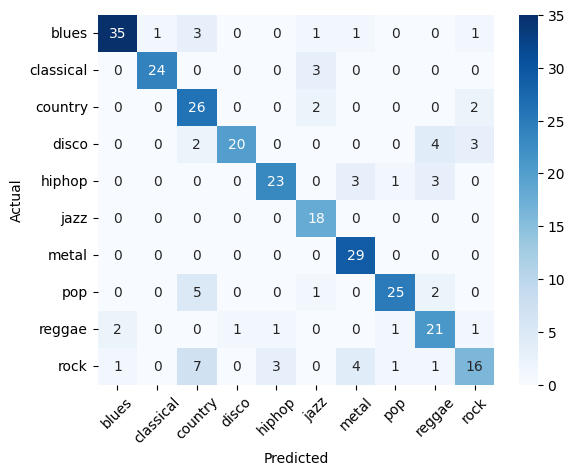

In [ ]:
confusion_mtx = tf.math.confusion_matrix(labels, predicted)

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)
plt.show()